In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import pickle

In [2]:
data = pd.read_csv('/kaggle/input/tweeter-covid-surabaya/dataset_twitter-scraper_2023-12-05_16-03-34-228.csv')

In [3]:
data.head()

,conversation_id_str,lang,full_text
0,1731974001801810075,in,@arifin34533 @reza_nukleuz Di potcast² dia jel...
1,1731864307640729785,en,"4-20-2023: Surabaya, Indonesia:\n""We studied ..."
2,1731684506078228874,in,Plissss lah\nMasa w ke surabaya pas covid mulu...
3,1731677766074925248,en,"This was a fuel stop in Surabaya, Indonesia - ..."
4,1731241963033358710,in,@dayroraxy @Widino Mutiara yang enak di keluar...


In [4]:
data = data[data['lang'] == 'in']

In [5]:
data.head()

,conversation_id_str,lang,full_text
0,1731974001801810075,in,@arifin34533 @reza_nukleuz Di potcast² dia jel...
2,1731684506078228874,in,Plissss lah\nMasa w ke surabaya pas covid mulu...
4,1731241963033358710,in,@dayroraxy @Widino Mutiara yang enak di keluar...
5,1731302651290390978,in,"Profil Doni Monardo, Mantan Kepala BNPB dan Ke..."
6,1731301887755075865,in,Doni Monardo Mantan Ketua Satgas Covid-19 Berp...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2045 entries, 0 to 2210
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   conversation_id_str  2045 non-null   int64 
 1   lang                 2045 non-null   object
 2   full_text            2045 non-null   object
dtypes: int64(1), object(2)
memory usage: 63.9+ KB


In [7]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

nltk_stw_id = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [9]:
import re


def preprocess(textdata, stopwords_id, emojis):
    processedText = []

    # Create Lemmatizer
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9\s]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower();
        
        tweet = re.sub(r'\s+', ' ', tweet).strip()

        # Replace all URLs with 'URL'
        tweet = re.sub(urlPattern, ' URL', tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace @USERNAME with 'USER'.
        tweet = re.sub(userPattern, ' USER', tweet)
        # Replace all non-alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letters.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        #Replace more than 1 blank space to only one
        tweet = re.sub(r'\s+', ' ', tweet).strip()
        
        #Replace number or digit to 'NUM'
        tweet = re.sub(r'\d+', ' NUM ', tweet)
        
        #Remove special tags
        tweet=re.sub("&lt;/?.*?&gt;","&lt;&gt;",tweet)

        tweetwords = ''
        
        for word in tweet.split():
            # Checking if the word is a stopword.
            # if word not in stopwords_en and word not in stopwords_id:
            if word not in stopwords_id:
                if len(word) > 1:
                    # Lemmatizing the word.
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word + ' ')

        processedText.append(tweetwords)

    return processedText

In [10]:
emojis_dict = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [11]:
data['processed_text'] = preprocess(data['full_text'], nltk_stw_id, emojis_dict)
print(data[['full_text', 'processed_text']].head(10))

                                            full_text  \
0   @arifin34533 @reza_nukleuz Di potcast² dia jel...   
2   Plissss lah\nMasa w ke surabaya pas covid mulu...   
4   @dayroraxy @Widino Mutiara yang enak di keluar...   
5   Profil Doni Monardo, Mantan Kepala BNPB dan Ke...   
6   Doni Monardo Mantan Ketua Satgas Covid-19 Berp...   
7   BI sebut QRIS Selamatkan Indonesia dari Krisis...   
8   @kompascom Buanyak sekali usia 40 an yg pengan...   
9   @Aditya5803 @widodo_naufal @Goldmind_82 Tapi h...   
10  @mawakresna @widiguruh @gibran_tweet - Kota So...   
11  @FiersaBesari 2 tahun lalu dunia bener2 runtuh...   

                                       processed_text  
0   USER USER potcast jelasin koq ma sarung tangan...  
2                   pliss surabaya pa covid mulu dah   
4   USER USER mutiara enak keluarga btw bakpia tug...  
5   profil doni monardo mantan kepala bnpb ketua s...  
6   doni monardo mantan ketua satgas covid NUM ber...  
7   bi qris selamatkan indonesia kri

In [12]:
from spacy.lang.id import Indonesian

spacy_id = Indonesian()
tokenized_texts = []

for text in data['processed_text']:
    word_tokens = spacy_id(text)
    tokenized_texts.append([token.text for token in word_tokens])

# Menambahkan kolom baru 'word_tokens' ke dalam DataFrame
data['word_tokens'] = tokenized_texts

# Menampilkan hasil
for index, row in data.head(10).iterrows():
    print(f"Index: {index}")
    print(f"\nWord Tokens: {row['word_tokens']}\n")
    print(f"Processed Text: {row['processed_text']}")
    print("\n" + "-"*50 + "\n")

Index: 0

Word Tokens: ['USER', 'USER', 'potcast', 'jelasin', 'koq', 'ma', 'sarung', 'tangan', 'tsb', 'kebiasaan', 'seno', 'terlibat', 'aktif', 'relawan', 'penanggulangan', 'covid', 'NUM', 'surabaya']

Processed Text: USER USER potcast jelasin koq ma sarung tangan tsb kebiasaan seno terlibat aktif relawan penanggulangan covid NUM surabaya 

--------------------------------------------------

Index: 2

Word Tokens: ['pliss', 'surabaya', 'pa', 'covid', 'mulu', 'dah']

Processed Text: pliss surabaya pa covid mulu dah 

--------------------------------------------------

Index: 4

Word Tokens: ['USER', 'USER', 'mutiara', 'enak', 'keluarga', 'btw', 'bakpia', 'tugu', 'lapis', 'pahlawan', 'surabaya', 'bolu', 'susu', 'kembang', 'bandung', 'dkk', 'pnya', 'omset', 'NUM', 'triliun', 'covid', 'NUM']

Processed Text: USER USER mutiara enak keluarga btw bakpia tugu lapis pahlawan surabaya bolu susu kembang bandung dkk pnya omset NUM triliun covid NUM 

-----------------------------------------------

In [13]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5)
# X = tfidf_vectorizer.fit_transform(data['processed_text'])
# print(X.shape)
# print(X)

In [14]:
lexicon_negative = pd.read_csv('/kaggle/input/indo-sentiment-lexicon/negative.tsv', sep='\t')
lexicon_positive= pd.read_csv('/kaggle/input/indo-sentiment-lexicon/positive.tsv', sep='\t')

lexicon = pd.concat([lexicon_negative, lexicon_positive], ignore_index=True)

lexicon.head()

,word,weight
0,putus tali gantung,-2
1,gelebah,-2
2,gobar hati,-2
3,tersentuh (perasaan),-1
4,isak,-5


In [15]:
data.head()

,conversation_id_str,lang,full_text,processed_text,word_tokens
0,1731974001801810075,in,@arifin34533 @reza_nukleuz Di potcast² dia jel...,USER USER potcast jelasin koq ma sarung tangan...,"[USER, USER, potcast, jelasin, koq, ma, sarung..."
2,1731684506078228874,in,Plissss lah\nMasa w ke surabaya pas covid mulu...,pliss surabaya pa covid mulu dah,"[pliss, surabaya, pa, covid, mulu, dah]"
4,1731241963033358710,in,@dayroraxy @Widino Mutiara yang enak di keluar...,USER USER mutiara enak keluarga btw bakpia tug...,"[USER, USER, mutiara, enak, keluarga, btw, bak..."
5,1731302651290390978,in,"Profil Doni Monardo, Mantan Kepala BNPB dan Ke...",profil doni monardo mantan kepala bnpb ketua s...,"[profil, doni, monardo, mantan, kepala, bnpb, ..."
6,1731301887755075865,in,Doni Monardo Mantan Ketua Satgas Covid-19 Berp...,doni monardo mantan ketua satgas covid NUM ber...,"[doni, monardo, mantan, ketua, satgas, covid, ..."


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2045 entries, 0 to 2210
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   conversation_id_str  2045 non-null   int64 
 1   lang                 2045 non-null   object
 2   full_text            2045 non-null   object
 3   processed_text       2045 non-null   object
 4   word_tokens          2045 non-null   object
dtypes: int64(1), object(4)
memory usage: 95.9+ KB


In [17]:
search_lex_word = lexicon['word'].values
search_lex_word[:100]

array(['putus tali gantung', 'gelebah', 'gobar hati',
       'tersentuh (perasaan)', 'isak', 'larat hati', 'nelangsa',
       'remuk redam', 'tidak segan', 'gemar', 'tak segan', 'sesal',
       'pengen', 'penghayatan', 'absorpsi', 'linu', 'salah benang',
       'sakit', 'lara', 'zuhud', 'mencederai', 'mengingkari', 'maaf',
       'mengkhianat', 'mencelakai', 'mulu', 'ngga', 'borong', 'lever',
       'kasian', 'gamau', 'doang', 'pulas', 'abis', 'coba', 'kangen',
       'kalau', 'maunya', 'seandainya', 'marilah', 'bener', 'yaudah',
       'nggak', 'gatau', 'apaan', 'ngakak', 'atuh', 'sekali',
       'menarik hati', 'cedayam', 'kece', 'termakan', 'belom', 'malem',
       'mencekau', 'menduga', 'menyuarakan', 'memprediksi', 'membunyikan',
       'menerka', 'menaksir', 'mengantisipasi', 'nangis', 'rompok',
       'soalnya', 'griya', 'gubuk', 'anjir', 'putus jiwa',
       'berlalu dr dunia', 'putus nyawa', 'menarik napas penghabisan',
       'membuang nyawa', 'hilang hayat', 'putus napas', '

In [18]:
print("katanya" in search_lex_word)

True


In [19]:
word_tokens = data['word_tokens']

contain = 0
notcontain = 0

for words in word_tokens:
    flag = False
    for word in words:
        if word in search_lex_word:
            flag = True
            continue
    if flag:
        contain += 1
        continue
    notcontain += 1
    
    
print(contain, notcontain)

1688 357


In [20]:
bow = data[['processed_text', 'word_tokens']].copy()
bow.reset_index(drop=True)

,processed_text,word_tokens
0,USER USER potcast jelasin koq ma sarung tangan...,"[USER, USER, potcast, jelasin, koq, ma, sarung..."
1,pliss surabaya pa covid mulu dah,"[pliss, surabaya, pa, covid, mulu, dah]"
2,USER USER mutiara enak keluarga btw bakpia tug...,"[USER, USER, mutiara, enak, keluarga, btw, bak..."
3,profil doni monardo mantan kepala bnpb ketua s...,"[profil, doni, monardo, mantan, kepala, bnpb, ..."
4,doni monardo mantan ketua satgas covid NUM ber...,"[doni, monardo, mantan, ketua, satgas, covid, ..."
...,...,...
2040,meningkat jatim ketahui gejala covid arcturus ...,"[meningkat, jatim, ketahui, gejala, covid, arc..."
2041,organisasi kesehatan dunia who resmi mengumumk...,"[organisasi, kesehatan, dunia, who, resmi, men..."
2042,jadwal lokasi vaksin covid NUM surabaya NUM me...,"[jadwal, lokasi, vaksin, covid, NUM, surabaya,..."
2043,beritajatim jadwal lokasi vaksin covid NUM sur...,"[beritajatim, jadwal, lokasi, vaksin, covid, N..."


In [21]:
bow.tail()

,processed_text,word_tokens
2206,meningkat jatim ketahui gejala covid arcturus ...,"[meningkat, jatim, ketahui, gejala, covid, arc..."
2207,organisasi kesehatan dunia who resmi mengumumk...,"[organisasi, kesehatan, dunia, who, resmi, men..."
2208,jadwal lokasi vaksin covid NUM surabaya NUM me...,"[jadwal, lokasi, vaksin, covid, NUM, surabaya,..."
2209,beritajatim jadwal lokasi vaksin covid NUM sur...,"[beritajatim, jadwal, lokasi, vaksin, covid, N..."
2210,USER who bilang bebas covid walikota surabaya ...,"[USER, who, bilang, bebas, covid, walikota, su..."


In [22]:
bow.loc[2206]

processed_text    meningkat jatim ketahui gejala covid arcturus ...
word_tokens       [meningkat, jatim, ketahui, gejala, covid, arc...
Name: 2206, dtype: object

In [23]:

col_bow = np.array([])
bow_arr = np.zeros((len(bow["word_tokens"]), 0))

for row_idx, token in enumerate(bow["word_tokens"]):
    for word in token:
        if word in search_lex_word:
            weight = lexicon[lexicon['word'] == word].iloc[0]['weight']
            if word in col_bow:
                col_idx = np.where(col_bow == word)[0]
                bow_arr[row_idx, col_idx] = weight
            else:
                col_bow = np.append(col_bow, word)
                new_col = np.zeros((len(bow["word_tokens"]), 1))
                bow_arr = np.hstack([bow_arr, new_col])
                col_idx = np.where(col_bow == word)[0]
                bow_arr[row_idx, col_idx[-1]] = weight

print(bow_arr)

/tmp/ipykernel_19/1299090628.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if word in col_bow:


[[-3.  1.  3. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [24]:
bow_arr.shape

(2045, 1229)

In [25]:
row_sums = np.sum(bow_arr, axis=1)

# Reshape the row_sums to have a compatible shape for stacking
row_sums = row_sums.reshape(-1, 1)

# Horizontally stack the row sums to each row of the original array
bow_arr_with_sums = np.hstack((bow_arr, row_sums))

# Print the updated array with sums
print(bow_arr_with_sums)

[[-3.  1.  3. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0. -9.]
 [ 0.  0.  0. ...  0.  0. -9.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0. -6.]]


In [26]:
bow_arr_with_sums.shape

(2045, 1230)

In [27]:
col_bow = np.append(col_bow, "sentiment")

col_bow.shape

(1230,)

In [28]:
col_bow

array(['sarung', 'tangan', 'terlibat', ..., 'jatah', 'mematuhi',
       'sentiment'], dtype='<U32')

In [29]:
bow_arr_df = pd.DataFrame(bow_arr_with_sums, columns=col_bow)
bow_arr_df.tail()

,sarung,tangan,terlibat,aktif,penanggulangan,pa,mulu,dah,enak,keluarga,...,enek,memaafkan,ditunggu,masjid,kegembiraan,nikmat,shalat,jatah,mematuhi,sentiment
2040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-29.0
2041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0


In [30]:
bow = bow.reset_index(drop=True)
bow

,processed_text,word_tokens
0,USER USER potcast jelasin koq ma sarung tangan...,"[USER, USER, potcast, jelasin, koq, ma, sarung..."
1,pliss surabaya pa covid mulu dah,"[pliss, surabaya, pa, covid, mulu, dah]"
2,USER USER mutiara enak keluarga btw bakpia tug...,"[USER, USER, mutiara, enak, keluarga, btw, bak..."
3,profil doni monardo mantan kepala bnpb ketua s...,"[profil, doni, monardo, mantan, kepala, bnpb, ..."
4,doni monardo mantan ketua satgas covid NUM ber...,"[doni, monardo, mantan, ketua, satgas, covid, ..."
...,...,...
2040,meningkat jatim ketahui gejala covid arcturus ...,"[meningkat, jatim, ketahui, gejala, covid, arc..."
2041,organisasi kesehatan dunia who resmi mengumumk...,"[organisasi, kesehatan, dunia, who, resmi, men..."
2042,jadwal lokasi vaksin covid NUM surabaya NUM me...,"[jadwal, lokasi, vaksin, covid, NUM, surabaya,..."
2043,beritajatim jadwal lokasi vaksin covid NUM sur...,"[beritajatim, jadwal, lokasi, vaksin, covid, N..."


In [31]:
bow_arr_df = bow_arr_df.reset_index(drop=True)
bow_arr_df

,sarung,tangan,terlibat,aktif,penanggulangan,pa,mulu,dah,enak,keluarga,...,enek,memaafkan,ditunggu,masjid,kegembiraan,nikmat,shalat,jatah,mematuhi,sentiment
0,-3.0,1.0,3.0,-3.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,-5.0,-1.0,-3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,-3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-29.0
2041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
bow.tail()

,processed_text,word_tokens
2040,meningkat jatim ketahui gejala covid arcturus ...,"[meningkat, jatim, ketahui, gejala, covid, arc..."
2041,organisasi kesehatan dunia who resmi mengumumk...,"[organisasi, kesehatan, dunia, who, resmi, men..."
2042,jadwal lokasi vaksin covid NUM surabaya NUM me...,"[jadwal, lokasi, vaksin, covid, NUM, surabaya,..."
2043,beritajatim jadwal lokasi vaksin covid NUM sur...,"[beritajatim, jadwal, lokasi, vaksin, covid, N..."
2044,USER who bilang bebas covid walikota surabaya ...,"[USER, who, bilang, bebas, covid, walikota, su..."


In [33]:
ccat_df = pd.concat([bow, bow_arr_df], axis=1)
ccat_df.tail()

,processed_text,word_tokens,sarung,tangan,terlibat,aktif,penanggulangan,pa,mulu,dah,...,enek,memaafkan,ditunggu,masjid,kegembiraan,nikmat,shalat,jatah,mematuhi,sentiment
2040,meningkat jatim ketahui gejala covid arcturus ...,"[meningkat, jatim, ketahui, gejala, covid, arc...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-29.0
2041,organisasi kesehatan dunia who resmi mengumumk...,"[organisasi, kesehatan, dunia, who, resmi, men...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2042,jadwal lokasi vaksin covid NUM surabaya NUM me...,"[jadwal, lokasi, vaksin, covid, NUM, surabaya,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2043,beritajatim jadwal lokasi vaksin covid NUM sur...,"[beritajatim, jadwal, lokasi, vaksin, covid, N...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2044,USER who bilang bebas covid walikota surabaya ...,"[USER, who, bilang, bebas, covid, walikota, su...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0


In [34]:
ccat_df[ccat_df["sentiment"] > 0]

,processed_text,word_tokens,sarung,tangan,terlibat,aktif,penanggulangan,pa,mulu,dah,...,enek,memaafkan,ditunggu,masjid,kegembiraan,nikmat,shalat,jatah,mematuhi,sentiment
8,USER USER USER kota solo kota dgn pertumbuhan ...,"[USER, USER, USER, kota, solo, kota, dgn, pert...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
29,USER akuu deket rumah dah covid keknya surabay...,"[USER, akuu, deket, rumah, dah, covid, keknya,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
30,unusa diganjar penghargaan berkat kontribusiny...,"[unusa, diganjar, penghargaan, berkat, kontrib...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
32,USER halo min ayah vaksinasi covid usia NUM th...,"[USER, halo, min, ayah, vaksinasi, covid, usia...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
33,USER halo min ayah vaksinasi covid usia NUM th...,"[USER, halo, min, ayah, vaksinasi, covid, usia...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,hallo sahabat r bhayangkara samsoeri mertojoso...,"[hallo, sahabat, r, bhayangkara, samsoeri, mer...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2030,hallo sahabat r bhayangkara samsoeri mertojoso...,"[hallo, sahabat, r, bhayangkara, samsoeri, mer...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2034,USER malam ka dibandara juanda surabaya soekar...,"[USER, malam, ka, dibandara, juanda, surabaya,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2035,USER USER kak dibandara juanda surabaya soekar...,"[USER, USER, kak, dibandara, juanda, surabaya,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [35]:
sentiment_df = ccat_df[['processed_text','word_tokens', 'sentiment']].copy()
sentiment_df

,processed_text,word_tokens,sentiment
0,USER USER potcast jelasin koq ma sarung tangan...,"[USER, USER, potcast, jelasin, koq, ma, sarung...",0.0
1,pliss surabaya pa covid mulu dah,"[pliss, surabaya, pa, covid, mulu, dah]",-9.0
2,USER USER mutiara enak keluarga btw bakpia tug...,"[USER, USER, mutiara, enak, keluarga, btw, bak...",-9.0
3,profil doni monardo mantan kepala bnpb ketua s...,"[profil, doni, monardo, mantan, kepala, bnpb, ...",-14.0
4,doni monardo mantan ketua satgas covid NUM ber...,"[doni, monardo, mantan, ketua, satgas, covid, ...",-3.0
...,...,...,...
2040,meningkat jatim ketahui gejala covid arcturus ...,"[meningkat, jatim, ketahui, gejala, covid, arc...",-29.0
2041,organisasi kesehatan dunia who resmi mengumumk...,"[organisasi, kesehatan, dunia, who, resmi, men...",1.0
2042,jadwal lokasi vaksin covid NUM surabaya NUM me...,"[jadwal, lokasi, vaksin, covid, NUM, surabaya,...",0.0
2043,beritajatim jadwal lokasi vaksin covid NUM sur...,"[beritajatim, jadwal, lokasi, vaksin, covid, N...",0.0


In [36]:
def label_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'
    
sentiment_df['sentiment_label'] = sentiment_df['sentiment'].apply(label_sentiment)

sentiment_df.tail()

,processed_text,word_tokens,sentiment,sentiment_label
2040,meningkat jatim ketahui gejala covid arcturus ...,"[meningkat, jatim, ketahui, gejala, covid, arc...",-29.0,negative
2041,organisasi kesehatan dunia who resmi mengumumk...,"[organisasi, kesehatan, dunia, who, resmi, men...",1.0,positive
2042,jadwal lokasi vaksin covid NUM surabaya NUM me...,"[jadwal, lokasi, vaksin, covid, NUM, surabaya,...",0.0,neutral
2043,beritajatim jadwal lokasi vaksin covid NUM sur...,"[beritajatim, jadwal, lokasi, vaksin, covid, N...",0.0,neutral
2044,USER who bilang bebas covid walikota surabaya ...,"[USER, who, bilang, bebas, covid, walikota, su...",-6.0,negative


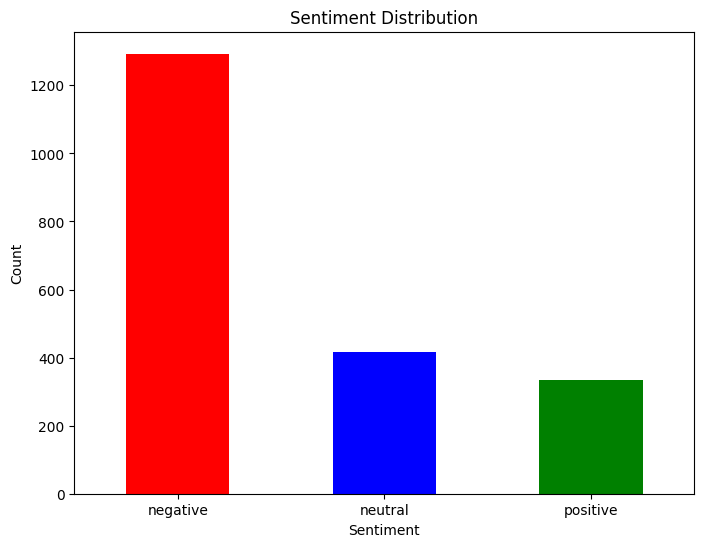

In [37]:
sentiment_counts = sentiment_df['sentiment_label'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'blue', 'green']) 
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

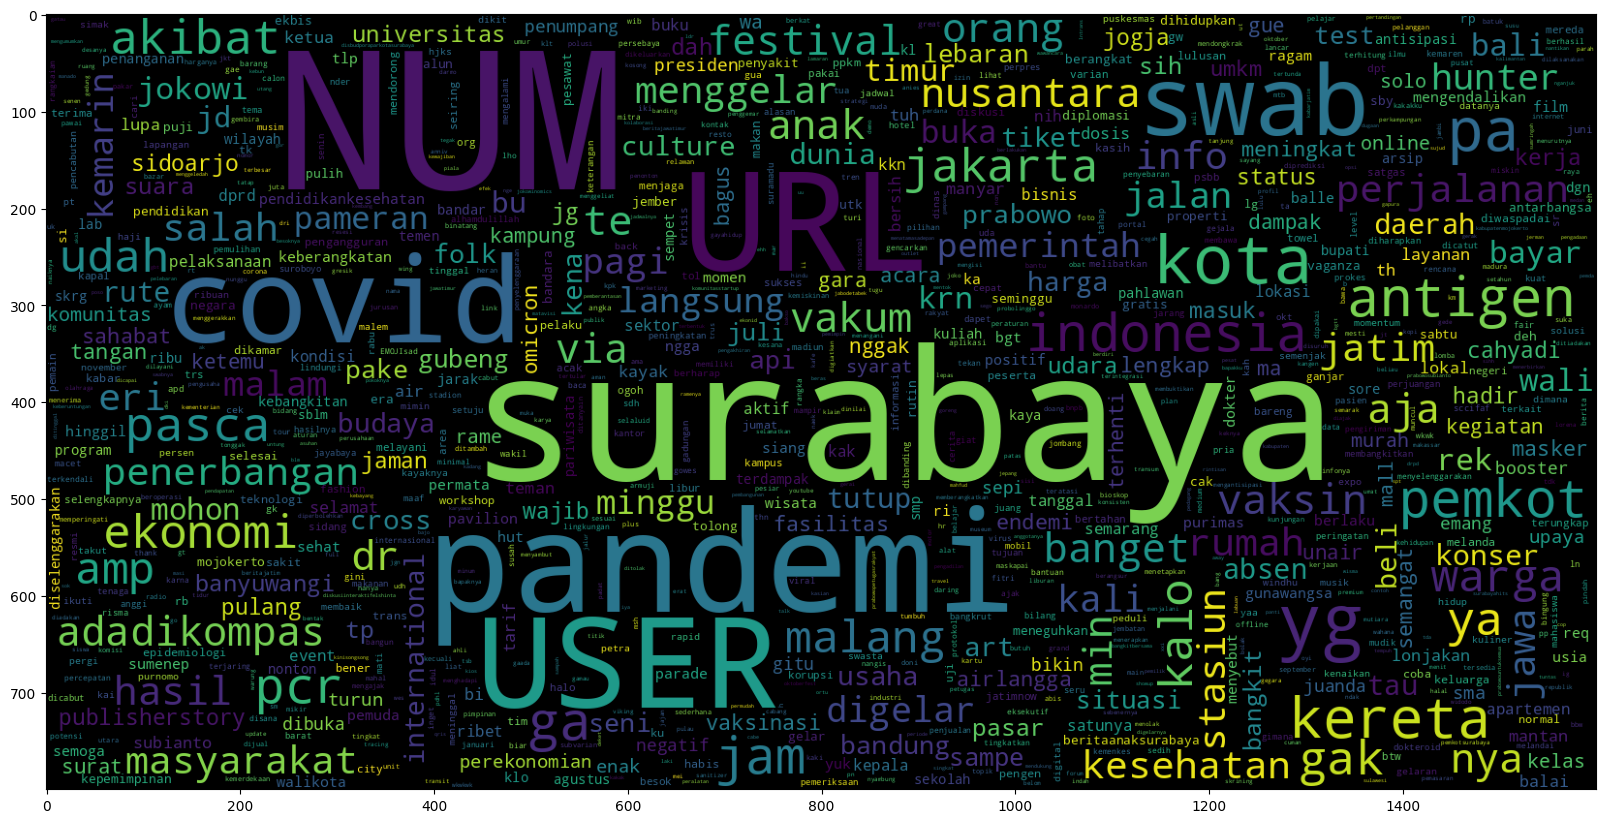

In [38]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

data_neg = sentiment_df[sentiment_df["sentiment_label"] == "negative"]["processed_text"]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

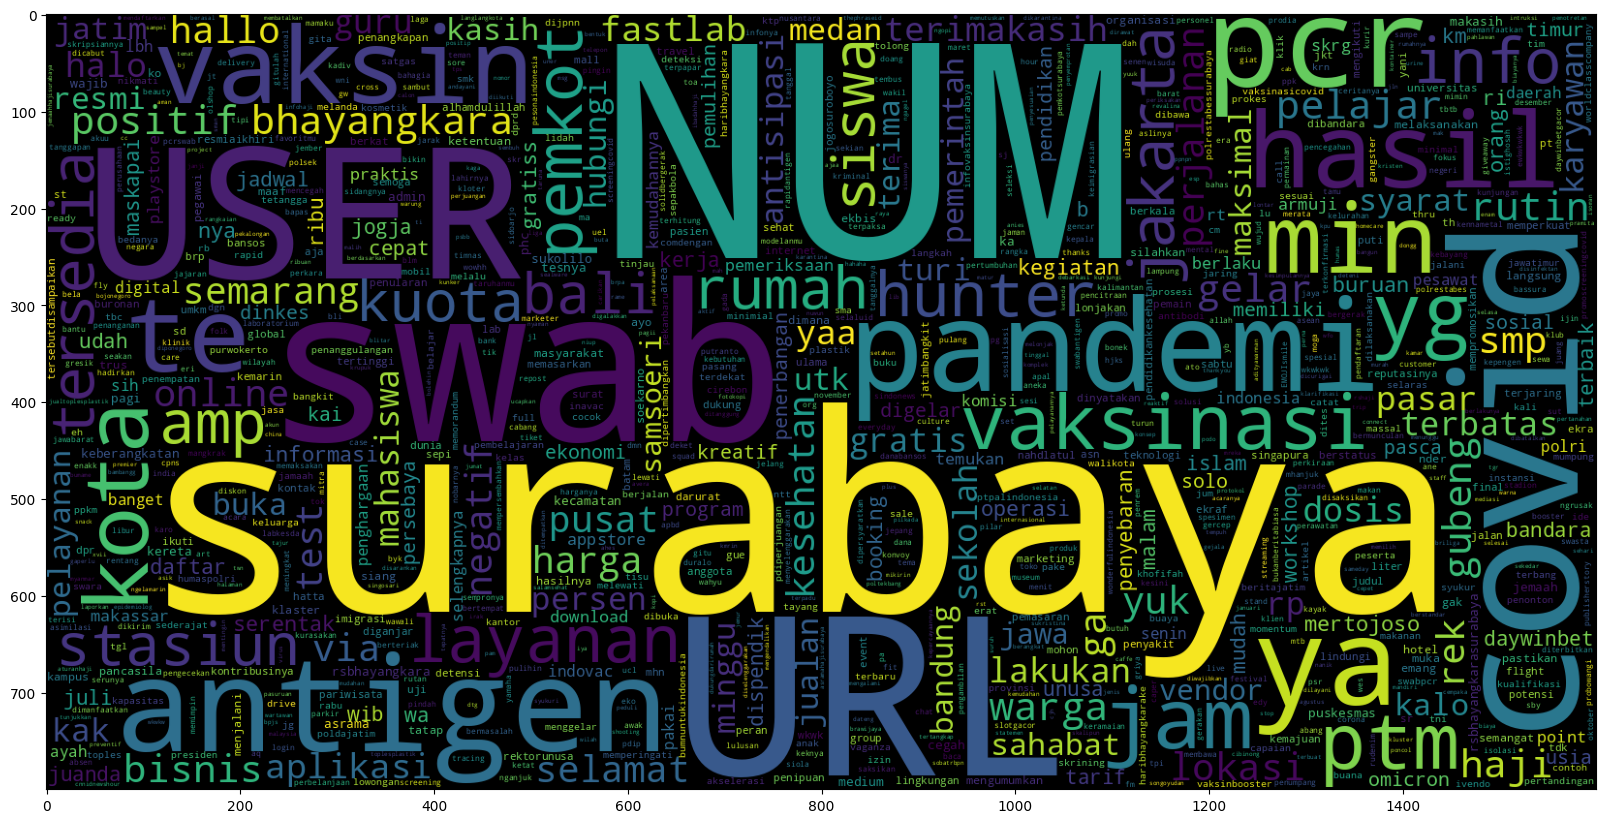

In [39]:
data_pos = sentiment_df[sentiment_df["sentiment_label"] == "positive"]["processed_text"]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

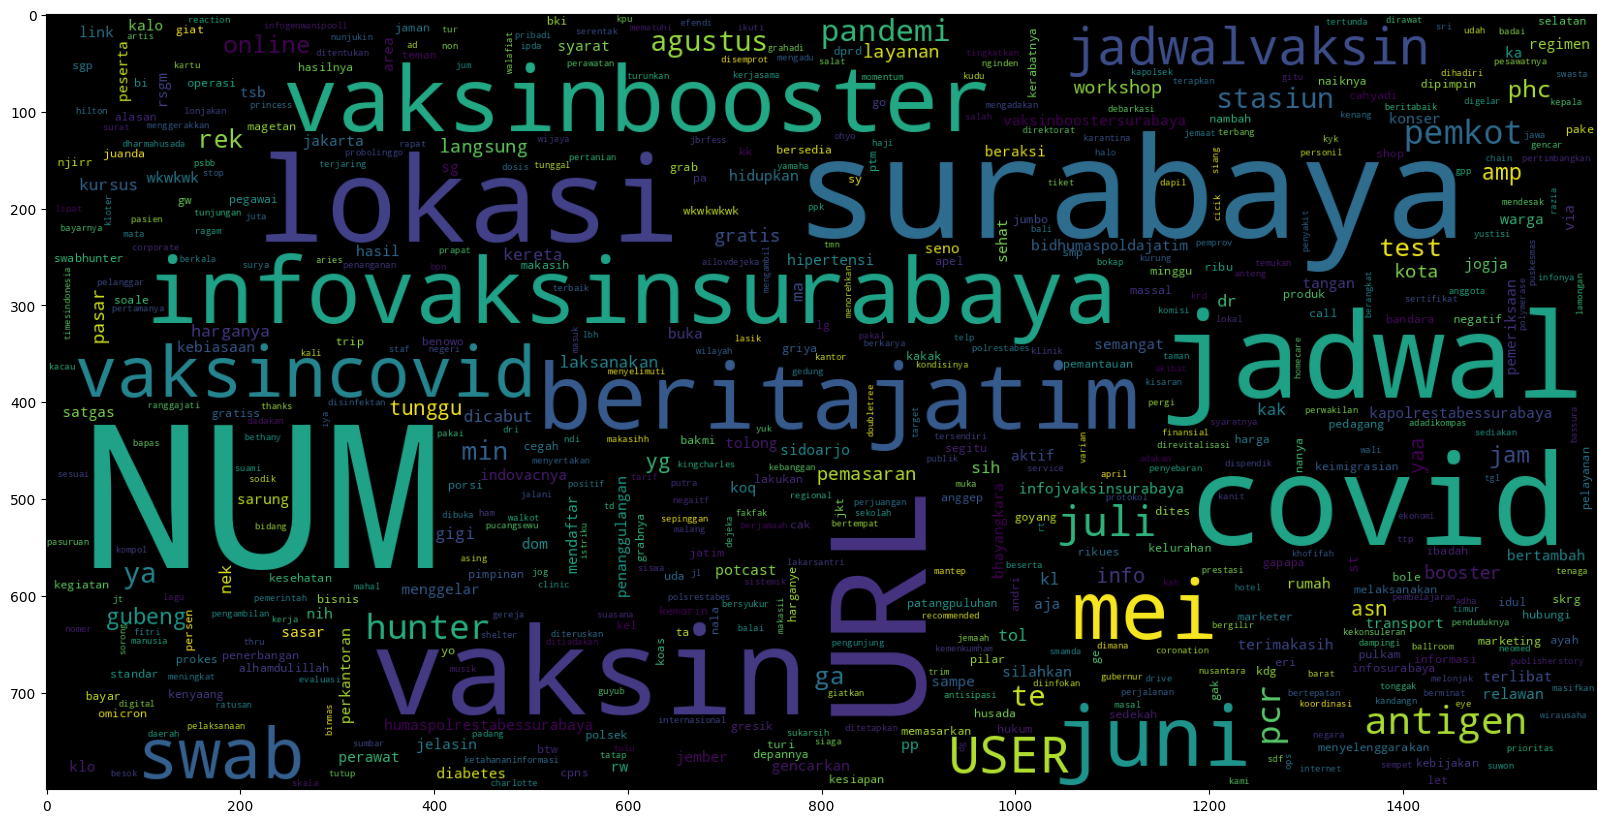

In [40]:
data_neu = sentiment_df[sentiment_df["sentiment_label"] == "neutral"]["processed_text"]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neu))
plt.imshow(wc)

In [41]:
# representasi vektor dengan VSM-TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

processedtext = sentiment_df["processed_text"]
sentiment = sentiment_df["sentiment_label"]

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
X = tfidf_vectorizer.fit_transform(processedtext)
print(X.shape)

(2045, 2931)


In [42]:
from sklearn import cluster

k = 3
seed = 99
km = cluster.KMeans(n_clusters=k, init='random', max_iter=300, random_state = seed)
km.fit(X)
'Done'

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'Done'

In [43]:
# Hasil clusteringnya
C_km = km.predict(X)
C_km[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [44]:
kmPP = cluster.KMeans(n_clusters=k, init='k-means++', max_iter=300, tol=0.0001, random_state = seed)
kmPP.fit(X)
C_kmpp = kmPP.predict(X)
C_kmpp[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [45]:
from sklearn.metrics import silhouette_score as siluet
C = [C_km, C_kmpp]

for res in C:
    print(siluet(X,res), end=', ')

0.06733444824743214, 0.06734016537881779, 

In [46]:
from sklearn.metrics import normalized_mutual_info_score as NMI

for res in C:
    print(NMI(sentiment,res), end=', ')

0.37262928975941556, 0.37423617369052864, 

In [47]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# def plot_tsne_pca(data, labels):
#     max_label = max(labels)
    
#     pca = PCA(n_components=2).fit_transform(data.todense())
#     tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
#     idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
#     label_subset = labels[max_items]
#     label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
#     f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
#     ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
#     ax[0].set_title('PCA Cluster Plot')
    
#     ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
#     ax[1].set_title('TSNE Cluster Plot')

# plot_tsne_pca(X, C_kmpp)

In [48]:
label = sentiment
print(label)

print(len(label))
print(len(processedtext))
print(len(X.getnnz(1)))
print(X.shape)

0        neutral
1       negative
2       negative
3       negative
4       negative
          ...   
2040    negative
2041    positive
2042     neutral
2043     neutral
2044    negative
Name: sentiment_label, Length: 2045, dtype: object
2045
2045
2045
(2045, 2931)


In [49]:
Y = label[X.getnnz(1)>0]
X_clear = X[X.getnnz(1)>0]

# Hapus dokumen yang memiliki nilai row 0
docs_nonzero = list()
for i, d in enumerate(X.getnnz(1)>0):
    if d:
        docs_nonzero.append(processedtext[i])

print(X_clear.shape, len(Y), len(docs_nonzero))

(2045, 2931) 2045 2045


In [50]:
# Membagi data menjadi dua yaitu data training dan data testing
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_clear, Y, test_size=.3, random_state=8989)
print(X_train.shape, X_test.shape)

(1431, 2931) (614, 2931)


In [51]:
# KNN menggunakan scikit-learn library
# http://scikit-learn.org/stable/modules/neighbors.html
from sklearn import neighbors

K = 3
weights = 'distance'
kNN = neighbors.KNeighborsClassifier(K, weights=weights)
kNN.fit(X_train, Y_train)
print('Done!')

Done!


In [52]:
# Prediksi dengan KNN
Y_knn = kNN.predict(X_test)

In [53]:
# Evaluasi dengan akurasi
from sklearn.metrics import accuracy_score

accuracy_score(Y_test, Y_knn)

0.8469055374592834

In [54]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [55]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
# print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.


In [56]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [57]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories = ['negative', 'positive', 'neutral']
    group_names = ['True Neg', 'False Pos', 'False Neu', 'False Neg', 'True Pos', 'False Neu', 'False Neg', 'False Pos', 'True Neu']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]

    # Check if the number of elements is correct for a 3x3 matrix
    labels = np.asarray(labels).reshape(3, 3)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)


              precision    recall  f1-score   support

    negative       0.74      1.00      0.85        65
     neutral       1.00      0.61      0.76        23
    positive       1.00      0.07      0.12        15

    accuracy                           0.78       103
   macro avg       0.91      0.56      0.58       103
weighted avg       0.84      0.78      0.72       103



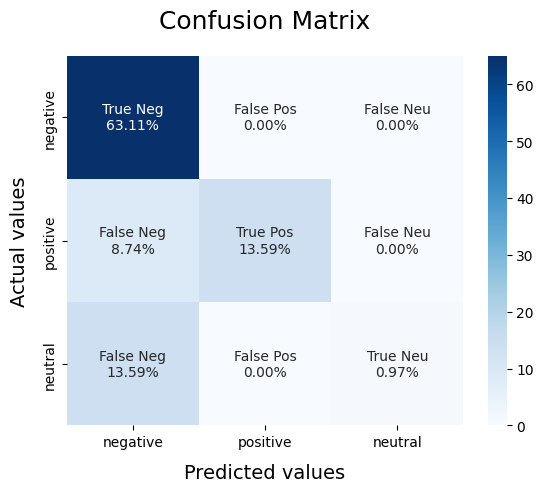

In [58]:
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

In [59]:
import pickle

file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()